In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

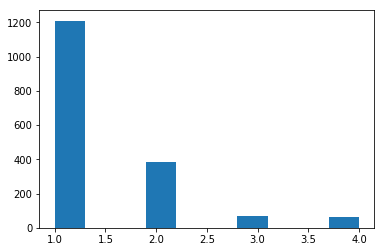

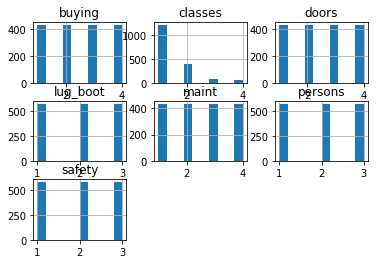

In [13]:
# classificação dos carros

UNACC = 3  # não aceitável
ACC = 1    # aceitável
GOOD = 2   # bom
VG = 4     # Muito bom

seed = 20#12#7  # para manter todos os resultados reproduziveis
np.random.seed(seed)

# load dataset
dataframe = pd.read_csv(r"https://raw.githubusercontent.com/Pedro-Magalhaes/Teste/master/t1_2/car_evaluation.csv")

# Assign names to Columns
dataframe.columns = ['buying','maint','doors','persons','lug_boot','safety','classes']

# Encode Data, transformando o valor dos atributos de strings para numeros
dataframe.buying.replace(('vhigh','high','med','low'),(1,2,3,4), inplace=True)
dataframe.maint.replace(('vhigh','high','med','low'),(1,2,3,4), inplace=True)
dataframe.doors.replace(('2','3','4','5more'),(1,2,3,4), inplace=True)
dataframe.persons.replace(('2','4','more'),(1,2,3), inplace=True)
dataframe.lug_boot.replace(('small','med','big'),(1,2,3), inplace=True)
dataframe.safety.replace(('low','med','high'),(1,2,3), inplace=True)
dataframe.classes.replace(('unacc','acc','good','vgood'),(1,2,3,4), inplace=True)

dataset = dataframe.values

# x -> atributos do problema são 5, de 0 até 5
X = dataset[:,0:6]
# Y -> classificação de cada caso, coluna 6 do dataframe
Y = np.asarray(dataset[:,6], dtype="S6")
# Usando a função do sklearn para separar os casos de treino e de teste
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2)

def showDataHist(dataFrame):
        # Criando o Histograma com a distribuição das classes
        plt.hist(dataframe.classes)
        # Histograma de cada atributo do problema
        dataframe.hist()
        k = [3,5,7,9,11]
        y = [0.9050925925925926,0.9050925925925926,0.9606481481481481,0.9467592592592593,0.9259259259259259]
        plt.plot(k,y)
        plt.show()
showDataHist(dataframe)
#proporcao_aceitalvel = len([Y['classes']==1]]) / len(Y)
#proporcao_aceitalvel

In [14]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

def printResults(errosSum,accuracy):
    # imprimindo o numero de elementos classificados errados
    print('Misclassified samples using SVM are: {}'.format(errosSum))
    # imprimindo a acuracia
    print('Classification Accuracy of SVM is {} '.format(accuracy))


# Fazendo a standartização dos dados ler o site a seguir para explicação:
# Obtivemos resultados melhores ulizando esse passo
#  https://towardsdatascience.com/effect-of-feature-standardization-on-linear-support-vector-machines-13213765b812
def standartizeTrainData(X_Train,X_Test):   
    sc = StandardScaler()
    sc.fit(X_Train)
    X_train_std=sc.transform(X_Train)
    X_test_std=sc.transform(X_Test)
    return X_test_std, X_train_std

def standartize(data):
    sc = StandardScaler()
    sc.fit(data)
    data_std=sc.transform(data)        
    return data_std

def trainSVM(X_Train,X_Test,Y_Train,Y_Test):
    start = time.time()
    X_test_std,X_train_std = standartizeTrainData(X_Train,X_Test)
    # https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
    # kernel é o tipo de formulação matematica do svm, ebf é "Radial Basis Function"
    # exp( -gamma * (|| x - x' ||)^2 )
    # O parametro C quanto 
    svc = svm.SVC(kernel='rbf', C = 7,gamma = 0.4)
    svc.fit(X_train_std,Y_Train)
    print('tempo de treino: {}s'.format(time.time()-start))
    start = time.time()
    s_pred=svc.predict(X_test_std)
    print('tempo de classificação dos casos de teste: {}s'.format(time.time()-start))
    accuracy = accuracy_score(Y_Test,s_pred)
    errosSum = (Y_Test!=s_pred).sum()
    return svc, Y_Test, s_pred, accuracy, errosSum


svc, Y_Test, s_pred, accuracy, errosSum = trainSVM(X_Train,X_Test,Y_Train,Y_Test)
printResults(errosSum,accuracy)

tempo de treino: 0.03402996063232422s
tempo de classificação dos casos de teste: 0.005004167556762695s
Misclassified samples using SVM are: 2
Classification Accuracy of SVM is 0.9942196531791907 


C:\Users\pfsma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
Y_Test


array([b'2', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1',
       b'2', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'2', b'1', b'1',
       b'1', b'4', b'1', b'1', b'1', b'1', b'3', b'2', b'1', b'2', b'1',
       b'1', b'2', b'1', b'1', b'1', b'1', b'1', b'4', b'2', b'2', b'2',
       b'4', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'3',
       b'1', b'1', b'2', b'1', b'1', b'1', b'1', b'4', b'1', b'2', b'1',
       b'1', b'1', b'4', b'1', b'1', b'1', b'2', b'1', b'3', b'1', b'2',
       b'1', b'1', b'1', b'1', b'2', b'1', b'1', b'2', b'2', b'1', b'1',
       b'1', b'1', b'1', b'3', b'1', b'1', b'1', b'1', b'3', b'1', b'1',
       b'1', b'3', b'1', b'1', b'1', b'3', b'1', b'1', b'1', b'1', b'1',
       b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1', b'1',
       b'1', b'4', b'1', b'1', b'1', b'1', b'1', b'2', b'2', b'1', b'3',
       b'4', b'2', b'2', b'2', b'2', b'1', b'1', b'1', b'1', b'1', b'1',
       b'1', b'1', b'1', b'2', b'2', b'1', b'1', b'

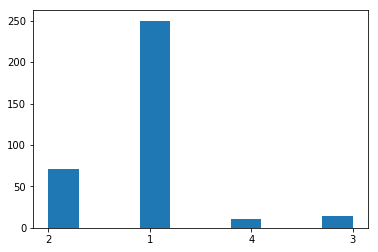

In [6]:
# temos muito mais casos de carros aceitaveis no nosso dataset
plt.hist(Y_Test)
plt.show()